# KAGGLE TITANIC COMPETITION


As we want to classify each passengers either as surivived(1) or not(0), it seems we have an example of logistic regression.
We have different columns on our data that might need to be transformed to fit our model.

It seems that in the name we can get some information about the title of the person(Mr, Ms, Dr, etc...). This could be useful to extract this information.


Embarked is the Port of Embarkation 	
C = Cherbourg, Q = Queenstown, S = Southampton
We can imagine that according to where you embark you have maybe different skills that we allowed you to survive or not

pclass is the Ticket class 	
1 = 1st, 2 = 2nd, 3 = 3rd

sibsp is the number of siblings / spouses aboard the Titanic

parch is the number of parents / children aboard the Titanic

I don't think in a first time that the ticket number is important as it does not give us indication where the passenger is located. In a first time i will not this feature.


In [1]:
import pandas as pd
import numpy as np
import os
import re

os.getcwd()
Xtrain=pd.read_csv('train.csv')
ytrain=Xtrain[['PassengerId','Survived']]
ytrain=ytrain.set_index(['PassengerId'])

Xtest=pd.read_csv('test.csv')

## Analysing of some of the fields

In [2]:
Xtrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
Xtest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can see that mainly the age and cabin is missing.For the fare as only one is missing in the test set we will fill it by the mean of the fares for the class of this person.
Let's check now what are the different factors that migh play a rold in the survival of the person.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
#Show value counts for two categorical variables
sns.countplot(x='Sex', hue='Survived', data=Xtrain)

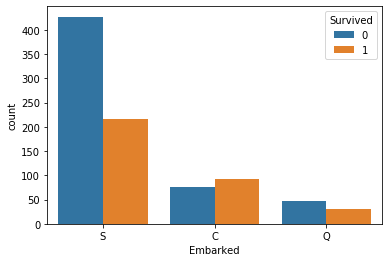

In [5]:
sns.countplot(x='Embarked', hue='Survived', data=Xtrain)


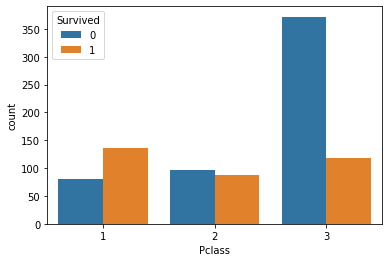

In [6]:
sns.countplot(x='Pclass', hue='Survived', data=Xtrain)


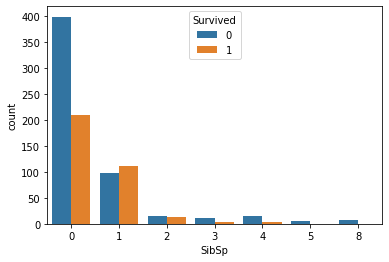

In [7]:
sns.countplot(x='SibSp', hue='Survived', data=Xtrain)

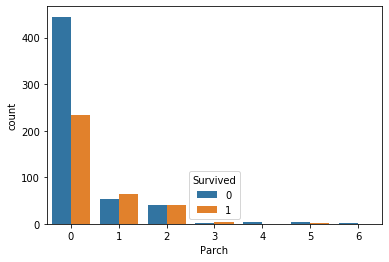

In [8]:
sns.countplot(x='Parch', hue='Survived', data=Xtrain)

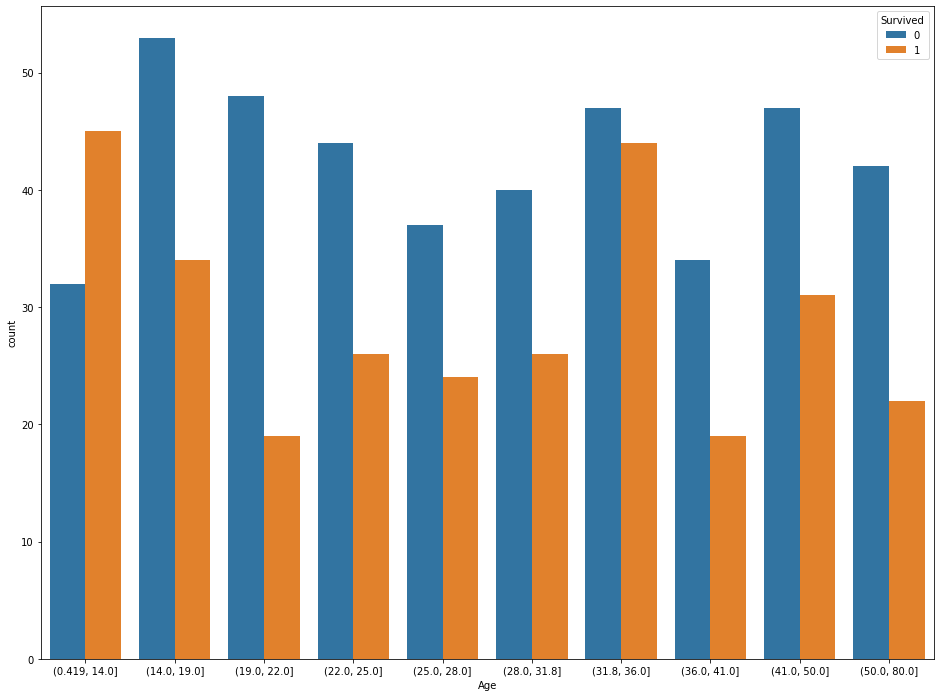

In [9]:
plt.figure(figsize=(16,12))
sns.countplot(x=pd.qcut(Xtrain['Age'],10), hue='Survived', data=Xtrain)
plt.show()

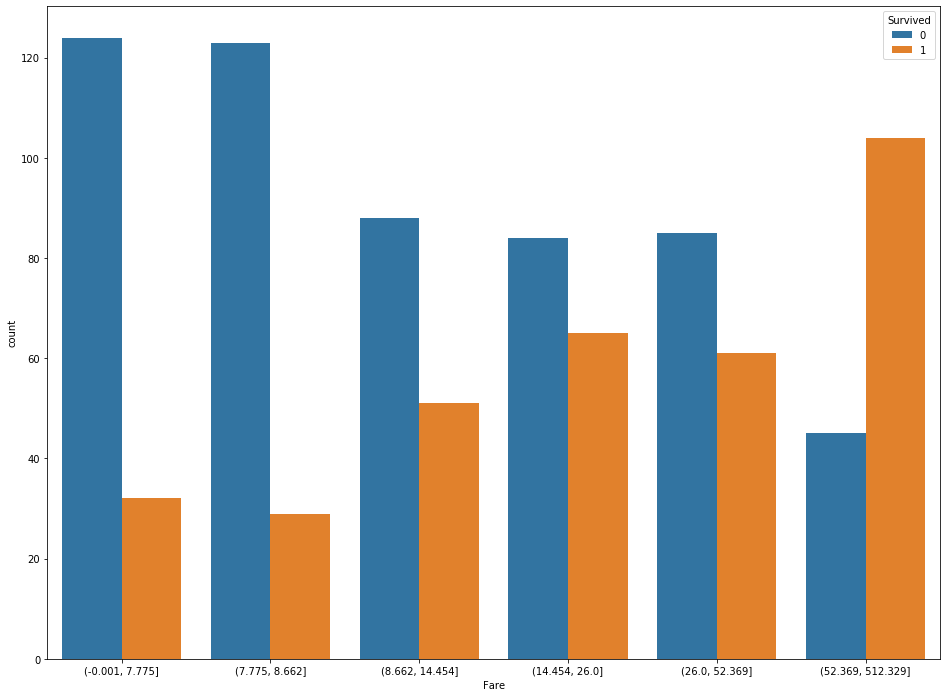

In [10]:
#Qcut cuts into bin according to the distribution
plt.figure(figsize=(16,12))
FareBins=pd.qcut(Xtrain['Fare'],6)
sns.countplot(x=pd.qcut(Xtrain['Fare'],6), hue='Survived', data=Xtrain)
plt.show()

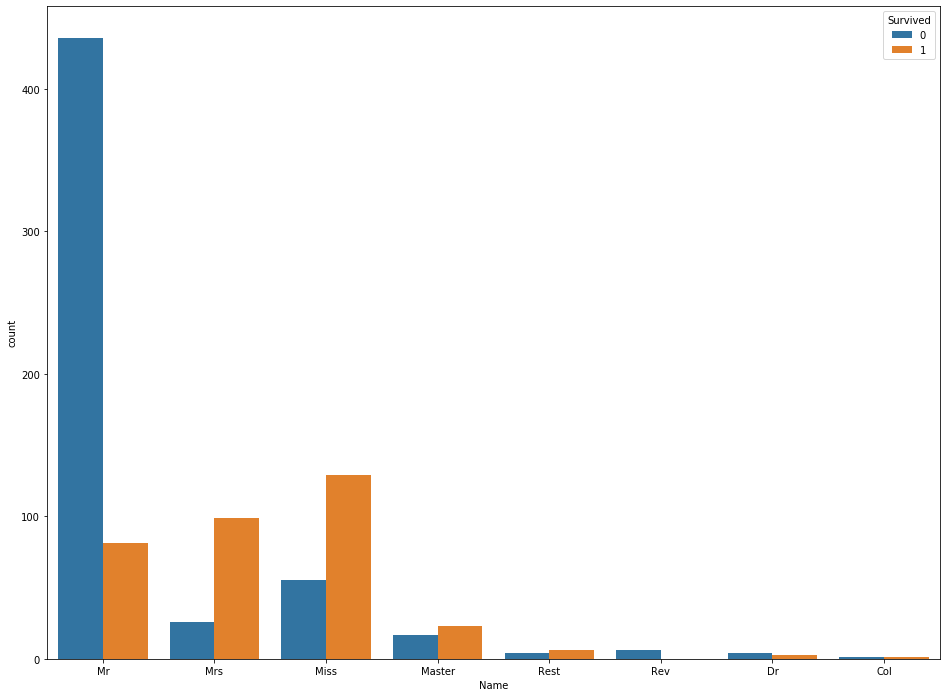

In [11]:
#Get the title from the name and fill the NA from the age according to this title
plt.figure(figsize=(16,12))
titles=Xtrain['Name'].apply(lambda x: re.split('. ',re.split(', ',x)[1])[0]).replace({ 'Jonkheer' : 'Rest', 'th' : 'Rest', 'Capt' : 'Rest','Don': 'Rest', 'Lady': 'Rest', 'Mlle': 'Rest', 'Major': 'Rest', 'Sir': 'Rest','Dona': 'Mrs','Ms': 'Miss','Mme': 'Miss'})
sns.countplot(x=titles, hue='Survived', data=Xtrain)
plt.show()

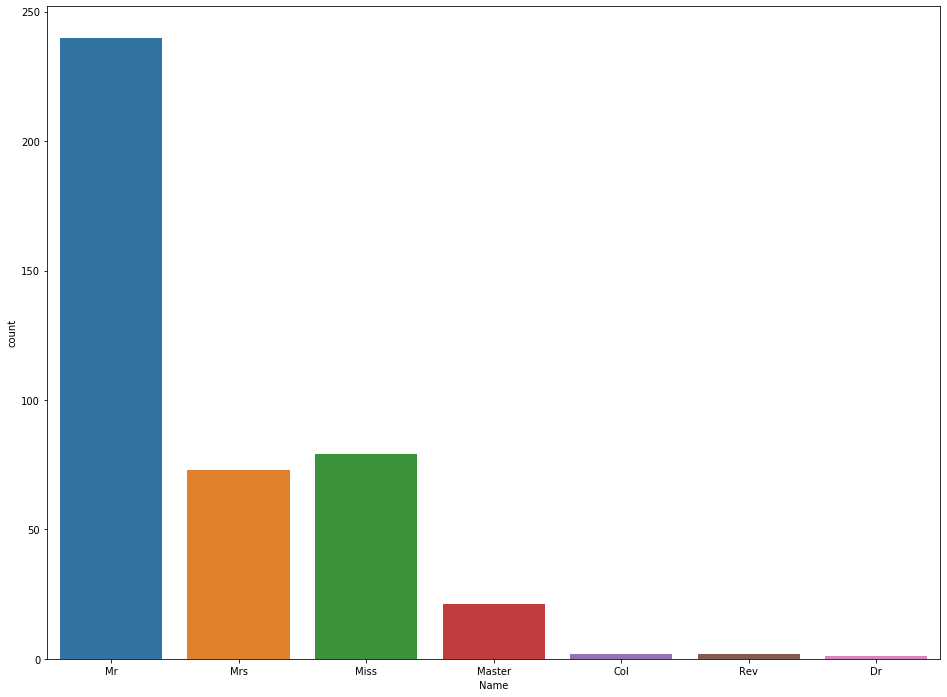

In [12]:
#Get the title from the name and fill the NA from the age according to this title
plt.figure(figsize=(16,12))
titles=Xtest['Name'].apply(lambda x: re.split('. ',re.split(', ',x)[1])[0]).replace({ 'Jonkheer' : 'Rest', 'th' : 'Rest', 'Capt' : 'Rest','Don': 'Rest', 'Lady': 'Rest', 'Mlle': 'Rest', 'Major': 'Rest', 'Sir': 'Rest','Dona': 'Mrs','Ms': 'Miss'})
sns.countplot(x=titles, data=Xtest)
plt.show()

#'Major' 'Sir'

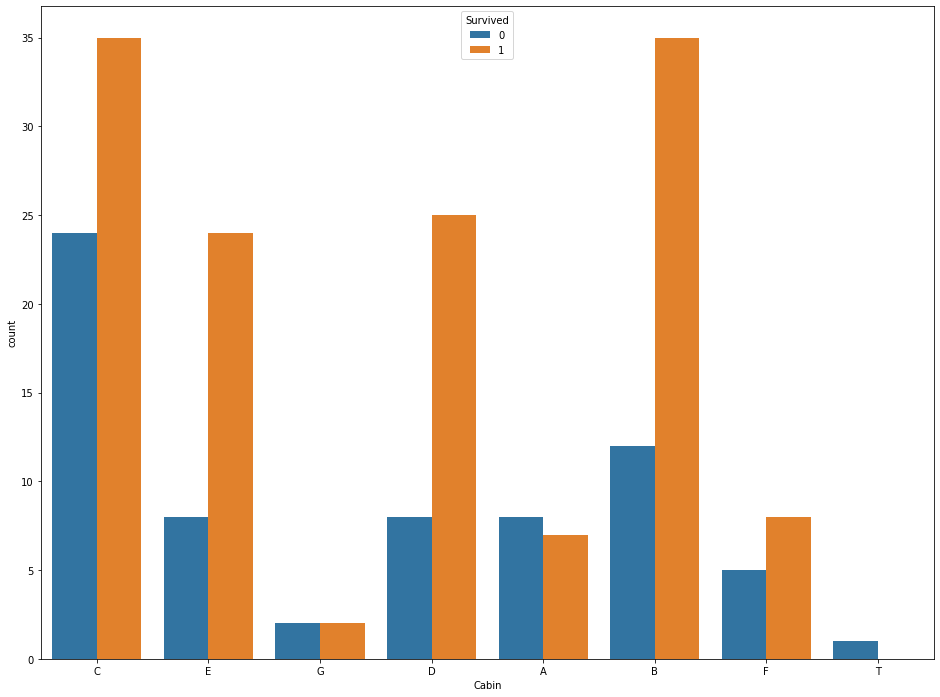

In [13]:
#Get the Cabin initial from the CAbin
plt.figure(figsize=(16,12))
CabinInitial=Xtrain['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else x)

sns.countplot(x=CabinInitial, hue='Survived', data=Xtrain)
plt.show()

In [14]:
Xtrain.iloc[:,1:].corr(method ='pearson')

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### Conclusion of the analyzys
It seems that the most important criterions are the sex, the class(which is correlated to the fare), the age.
But the age is partially incomplete, we will do then a linear model in order to estimate the age of the missing values. For this model we will parse the name in order to get the title of the person.

## Fill the NAN values and get rid of the unnecessary data

In [15]:
Xtrain[Xtrain['Embarked'].isnull()==True]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


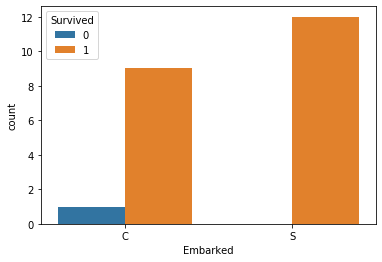

In [16]:
sns.countplot(x='Embarked', hue='Survived',data=Xtrain[(Xtrain['Pclass']==1) & (Xtrain['Fare']>=80) & (Xtrain['Cabin'].apply(lambda x: 'B' in x if pd.notnull(x) else False)==True)])
#We put Embarked to S for the two missing values as it seems that for their class and fare  most of the people embarked in S.
Xtrain['Embarked'].fillna('S', inplace=True)

In [17]:
#If Fare is missing get it from the mean for the class
Xtest['Fare']=Xtest['Fare'].fillna(Xtest[Xtest['Pclass']==1]['Fare'].mean())

### The Nan value for the age
To fill the Nan value for the age we will first clean our data and then we will create a model based on 
'TitleEncoded','Survived','Sex','Fare','SibSp','Parch','Pclass' to estimate the person's age.


In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
def cleanData(X):

    Embarked_dummies=pd.get_dummies(X['Embarked'], drop_first=True)
    Sex_dummies=pd.get_dummies(X['Sex'], drop_first=True)
    Pclass_dummies=pd.get_dummies(X['Pclass'], drop_first=True)
    X=pd.concat([X, Embarked_dummies], axis=1)
    X=pd.concat([X, Sex_dummies], axis=1)
    X=pd.concat([X, Pclass_dummies], axis=1)
    X.drop(['Sex','Embarked','Pclass'], axis=1, inplace=True)
    
    #Get the title from the name and fill the NA for the age, according to the title of the person
    X['Title']=X['Name'].apply(lambda x: re.split('. ',re.split(', ',x)[1])[0]).replace({ 'Jonkheer' : 'Rest', 'th' : 'Rest', 'Capt' : 'Rest','Don': 'Rest', 'Lady': 'Rest', 'Mlle': 'Rest', 'Major': 'Rest', 'Sir': 'Rest','Dona': 'Mrs','Ms': 'Miss','Mme': 'Miss'})
  
    #Title_dummies=pd.get_dummies(X['Title'], drop_first=True)
    #X=pd.concat([X, Title_dummies], axis=1)
    label_encoder = LabelEncoder()
    X['TitleEncoded'] = label_encoder.fit_transform(X['Title'])
    
    #X['CabinBool']=X['Cabin'].isna()==False
    
    X.drop(['Ticket','Name','Cabin','Title'], axis=1, inplace=True)
    
    X.set_index('PassengerId',inplace=True)
    X=X.sort_values(by='PassengerId',axis=0)
    return X

In [19]:
Xtrain=cleanData(Xtrain)
Xtest=cleanData(Xtest)
Xtest

,Age,SibSp,Parch,Fare,Q,S,male,2,3,TitleEncoded
PassengerId,,,,,,,,,,
892,34.5,0,0,7.8292,1,0,1,0,1,4
893,47.0,1,0,7.0000,0,1,0,0,1,5
894,62.0,0,0,9.6875,1,0,1,1,0,4
895,27.0,0,0,8.6625,0,1,1,0,1,4
896,22.0,1,1,12.2875,0,1,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...
1305,NaN,0,0,8.0500,0,1,1,0,1,4
1306,39.0,0,0,108.9000,0,0,0,0,0,5
1307,38.5,0,0,7.2500,0,1,1,0,1,4


In [20]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


def predictionAge(X):
    Xage=X.loc[:,['Age','TitleEncoded','Survived','male','Fare','SibSp','Parch',2,3]]
    Xagetrain=Xage[Xage['Age'].notnull()]
    Xageestimate=Xage[Xage['Age'].isnull()]
    yagetrain=Xagetrain['Age']   
    XagetrainNormalized=Xagetrain.drop(['Age'], axis=1)
    XageestimateNormalized=Xageestimate.drop(['Age'], axis=1)
    XagetrainNormalized=normalizingData(XagetrainNormalized)
    XageestimateNormalized=normalizingData(XageestimateNormalized)
    clf = LinearRegression().fit(XagetrainNormalized, yagetrain)
    yageestimate=clf.predict(XageestimateNormalized)
    yresults=pd.DataFrame(yageestimate, index=Xageestimate.index)
    yresults.rename(columns={0:'Age'}, inplace=True)
    #print(pd.concat([Xagetrain['Age'],yresults['Age']]).sort_values(axis=1, inplace=True))
    Concat=pd.DataFrame(pd.concat([Xagetrain['Age'],yresults['Age']]))
    Concat=Concat.sort_values(by='PassengerId')
    X['Age']=Concat['Age']
    return X

def predictionAge2(X,X2):
    Xage=X.loc[:,['Age','TitleEncoded','male','Fare','SibSp','Parch',2,3]]
    X2age=X2.loc[:,['Age','TitleEncoded','male','Fare','SibSp','Parch',2,3]]
    Xagefinal=pd.concat([Xage,X2age])
    Xagetrain=Xagefinal[Xagefinal['Age'].notnull()]
    Xageestimate=Xage[Xage['Age'].isnull()]
    yagetrain=Xagetrain['Age']   
    XagetrainNormalized=Xagetrain.drop(['Age'], axis=1)
    XageestimateNormalized=Xageestimate.drop(['Age'], axis=1)
    XagetrainNormalized=normalizingData(XagetrainNormalized)
    XageestimateNormalized=normalizingData(XageestimateNormalized)
    clf = LinearRegression().fit(XagetrainNormalized, yagetrain)
    yageestimate=clf.predict(XageestimateNormalized)
    yresults=pd.DataFrame(yageestimate, index=Xageestimate.index)
    yresults.rename(columns={0:'Age'}, inplace=True)
    #print(pd.concat([Xagetrain['Age'],yresults['Age']]).sort_values(axis=1, inplace=True))
    Concat=pd.DataFrame(pd.concat([Xagetrain['Age'],yresults['Age']]))
    Concat=Concat.sort_values(by='PassengerId')
    X['Age']=Concat['Age']
    return X




def normalizingData(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    '''X['Age']=(X['Age']-X['Age'].min())/(X['Age'].max()-X['Age'].min())
    X['Fare']=(X['Fare']-X['Fare'].min())/(X['Fare'].max()-X['Fare'].min())
    X['TitleEncoded']=(X['TitleEncoded']-X['TitleEncoded'].min())/(X['TitleEncoded'].max()-X['TitleEncoded'].min())
    X['SibSp']=(X['SibSp']-X['SibSp'].min())/(X['SibSp'].max()-X['SibSp'].min())
    X['Parch']=(X['Parch']-X['Parch'].min())/(X['Parch'].max()-X['Parch'].min())'''
    return X
    
    
    


In [21]:
Xtest=predictionAge2(Xtest, Xtrain)
Xtrain=predictionAge(Xtrain)


## The different models for estimating survived field
We will try with the clean data we have now to estimate the survived field with a simple logistic regression, then with a polynomial logistic regression of order 2.

First we split the train data into a train dataset and a testing dataset. 80%-20%

In [55]:
if 'Survived' in Xtrain.columns: Xtrain.drop(['Survived'], axis=1, inplace=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.1, random_state=0)

Then we do a logistic regression and check the score

In [59]:
from sklearn.linear_model import LogisticRegression
X_train=normalizingData(X_train)
X_test=normalizingData(X_test)
XtestNormalized=normalizingData(Xtest)
clf = LogisticRegression(solver='liblinear',random_state=0, max_iter=200).fit(X_train, y_train.values.ravel())
print('Score Train: '+str(clf.score(X_train, y_train)))
print('Score Test: '+str(clf.score(X_test, y_test)))



Score Train: 0.8177278401997503
Score Test: 0.8


In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        51
           1       0.82      0.69      0.75        39

    accuracy                           0.80        90
   macro avg       0.80      0.79      0.79        90
weighted avg       0.80      0.80      0.80        90



Then we do a polynomial logistic regression and check the score

In [57]:
#Trying polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly=poly.fit_transform(X_train)
clf3=LogisticRegression(solver='liblinear', max_iter=200).fit(X_poly,y_train.values.ravel())
X_polytest=poly.fit_transform(X_test)

In [62]:
print('Score on the training data is: ',clf3.score(X_poly, y_train))
print('Score on the testing data is: ',clf3.score(X_polytest, y_test))
X_polyfinaltest=poly.fit_transform(XtestNormalized)

Score on the training data is:  0.850187265917603
Score on the testing data is:  0.8222222222222222


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,11,1))}
]

# Create grid search object

clfgrid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clfgrid.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   20.8s finished
C:\Users\jc\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [28]:
print('Score Train: '+str(best_clf.score(X_train, y_train)))
print('Score Test: '+str(best_clf.score(X_test, y_test)))

Score Train: 0.9900124843945068
Score Test: 0.8


In [29]:
prediction=clf3.predict(X_polyfinaltest)


In [30]:
yfinal=pd.DataFrame()
yfinal['PassengerId']=Xtest.index
yfinal['Survived']=prediction
yfinal.to_csv('Results.csv',index=False)




## Conclusion
After cleaning the data, creating some new features and using a polynomial logistic regression we could estimate the people that survived for the titanic with an accuracy of 80%. 